In [1]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, assemble, execute
from qiskit import QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor 

In [2]:
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')

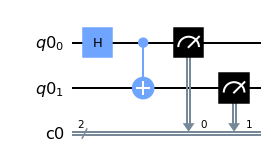

In [3]:
qr = QuantumRegister(2)
r = ClassicalRegister(2)
qc = QuantumCircuit(qr,r)
qc.h(0)
qc.cx(0,1)
qc.measure(qr,r)
qc.draw('mpl')

In [4]:
from qiskit.providers.aer import QasmSimulator
sim = QasmSimulator()

In [5]:
job = execute(qc, sim, shots=1024)
sim_counts = job.result().get_counts()

In [6]:
job = execute(qc, backend, shots=1024)
job_monitor(job)
qc_counts = job.result().get_counts()

Job Status: job has successfully run


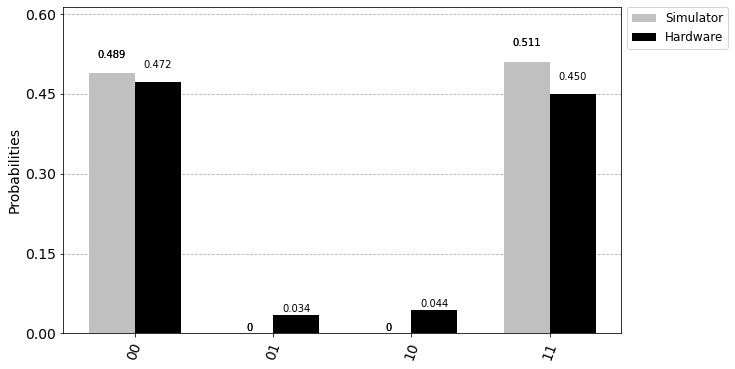

In [9]:
bell_fig = plt.figure(figsize=(10,6))
bell_ax = bell_fig.add_subplot()
plot_histogram([sim_counts, qc_counts], legend=['Simulator', 'Hardware'],color=['silver','black'],ax=bell_ax)
bell_fig.savefig('belem2_bellFig.pdf',bbox_inches='tight')